DataFrame contains NaN values: False


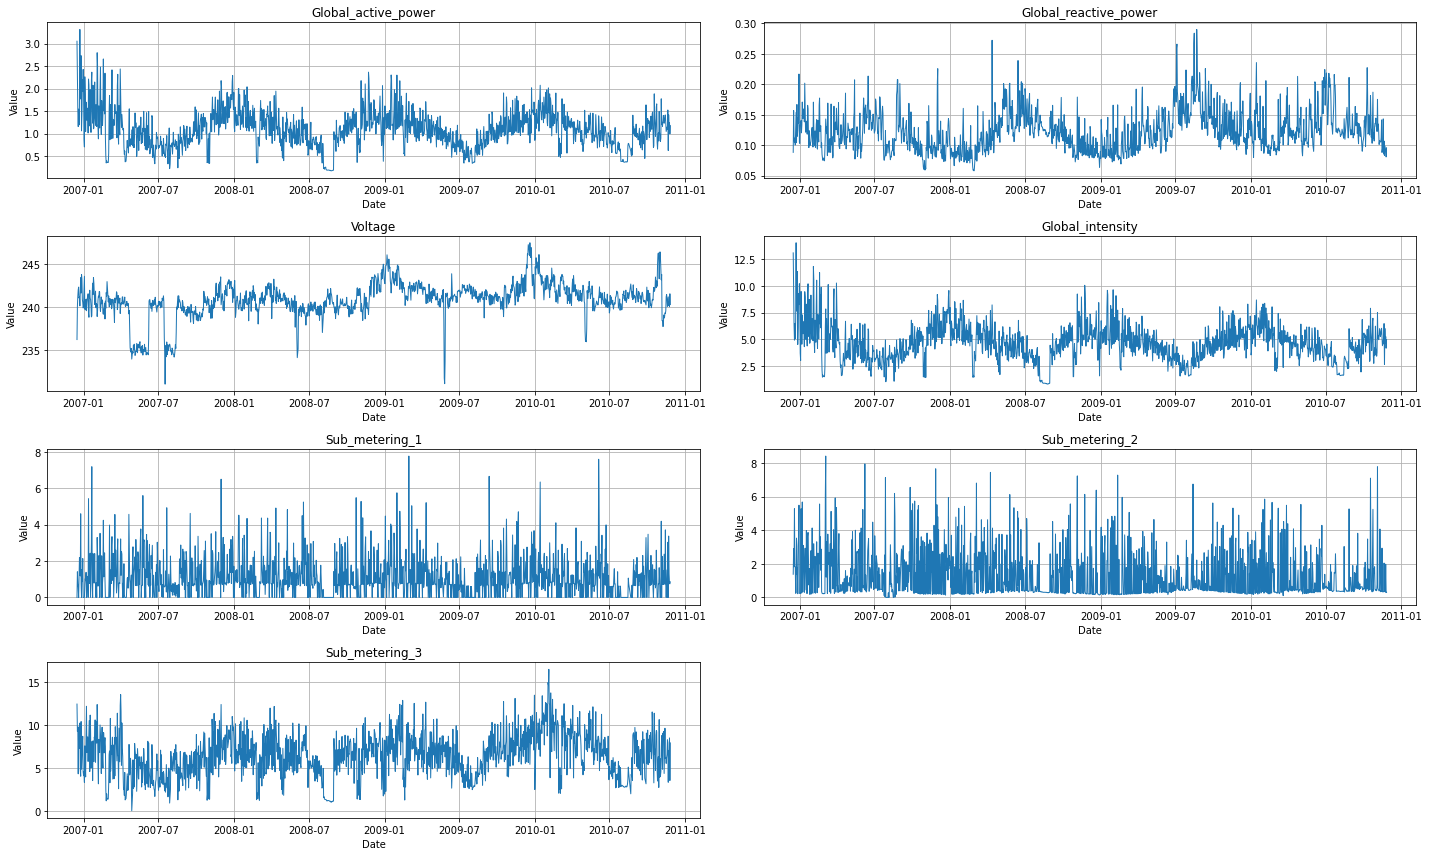

In [98]:
import pandas as pd
import torch
import matplotlib.pyplot as plt


dataset_file = 'household_power_consumption.txt'
data = pd.read_csv(dataset_file, sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')
data=data.dropna()
# Resample the data to have one value per day
daily_data = data.resample('D').mean()
daily_data = daily_data.dropna()
has_nans = daily_data.isna().any().any()

print(f"DataFrame contains NaN values: {has_nans}")
# Plot each time series
plt.figure(figsize=(20, 12))
for i, col in enumerate(daily_data.columns):
    plt.subplot(4, 2, i+1)
    plt.plot(daily_data.index, daily_data[col],linewidth=1)
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
time_series = daily_data.values
#time_series = torch.from_numpy(time_series).float()
print(time_series.shape)


(1433, 7)


In [100]:
x = torch.from_numpy(time_series[:-3]).float()
y = torch.from_numpy(time_series[12:]).float()
print(x.shape)
print(y.shape)




import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        # Forward pass through the fully connected layer
        out = self.fc(out[:, -1, :])

        return out


# Create an instance of the LSTM model
input_size = 7
hidden_size = 64
output_size = 7
lstm_model = LSTMModel(input_size, hidden_size, output_size)

# Reshape the input data to have 3 lags for each dimension
x = x.unfold(0, 10, 1).unsqueeze(2).reshape(-1, 10, input_size)

# Reshape the target data to match the size of the predicted tensor
y = y.reshape(-1, output_size)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)


print(x.shape)
print(y.shape)

# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    # Forward pass
    outputs = lstm_model(x)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([1430, 7])
torch.Size([1421, 7])
torch.Size([1421, 10, 7])
torch.Size([1421, 7])
Epoch [100/20000], Loss: 4538.2437
Epoch [200/20000], Loss: 2272.9167
Epoch [300/20000], Loss: 968.4200
Epoch [400/20000], Loss: 366.9942
Epoch [500/20000], Loss: 122.5998
Epoch [600/20000], Loss: 36.6103
Epoch [700/20000], Loss: 10.7739
Epoch [800/20000], Loss: 4.1810
Epoch [900/20000], Loss: 2.7568
Epoch [1000/20000], Loss: 2.4972
Epoch [1100/20000], Loss: 2.4575
Epoch [1200/20000], Loss: 2.4524
Epoch [1300/20000], Loss: 2.4519
Epoch [1400/20000], Loss: 2.4518
Epoch [1500/20000], Loss: 2.4518
Epoch [1600/20000], Loss: 2.4518
Epoch [1700/20000], Loss: 2.4518
Epoch [1800/20000], Loss: 2.4518
Epoch [1900/20000], Loss: 2.4519
Epoch [2000/20000], Loss: 2.4518
Epoch [2100/20000], Loss: 2.4524
Epoch [2200/20000], Loss: 2.4518
Epoch [2300/20000], Loss: 2.4518
Epoch [2400/20000], Loss: 2.3788
Epoch [2500/20000], Loss: 2.0677
Epoch [2600/20000], Loss: 2.0449
Epoch [2700/20000], Loss: 2.0222
Epoch [2800/

In [101]:
print(x.shape)
outputs.shape


torch.Size([1421, 10, 7])


torch.Size([1421, 7])

In [102]:
predicted = lstm_model(x).detach().numpy()

In [103]:
print(predicted)

[[1.2694153e+00 9.8927297e-02 2.4199179e+02 ... 1.1857407e+00
  1.4384923e+00 6.9197206e+00]
 [1.6890577e+00 1.1138181e-01 2.4039915e+02 ... 2.0634954e+00
  2.9939897e+00 8.5950661e+00]
 [1.6242713e+00 1.1548292e-01 2.4055528e+02 ... 1.8858891e+00
  3.5566943e+00 8.0539083e+00]
 ...
 [1.5047565e+00 1.2101985e-01 2.4092268e+02 ... 1.8220747e+00
  2.1568153e+00 8.9864244e+00]
 [7.3807013e-01 1.1111667e-01 2.4135535e+02 ... 5.1089287e-01
  6.1910403e-01 4.1868191e+00]
 [1.1975713e+00 1.0830370e-01 2.4150026e+02 ... 1.1947721e+00
  1.3683875e+00 6.7766957e+00]]


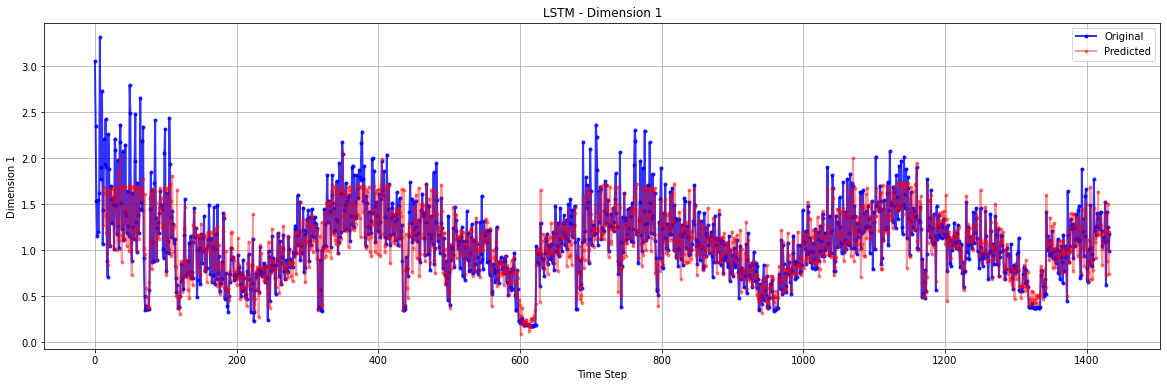

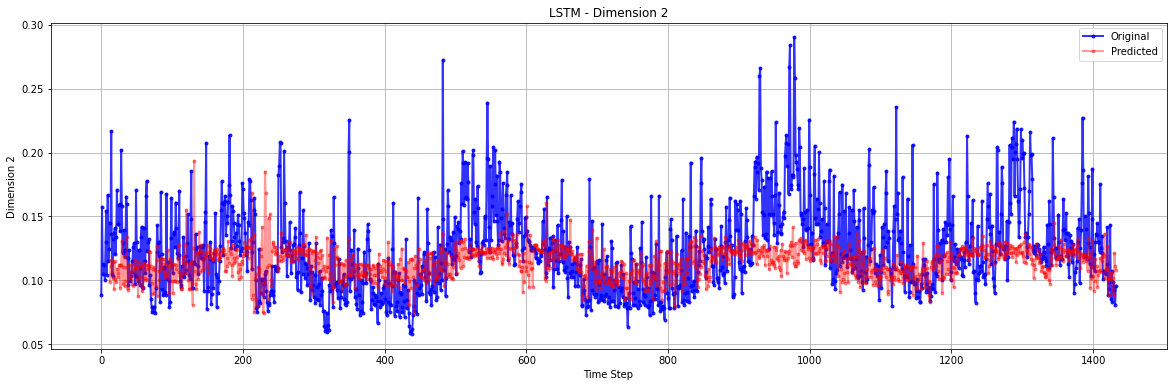

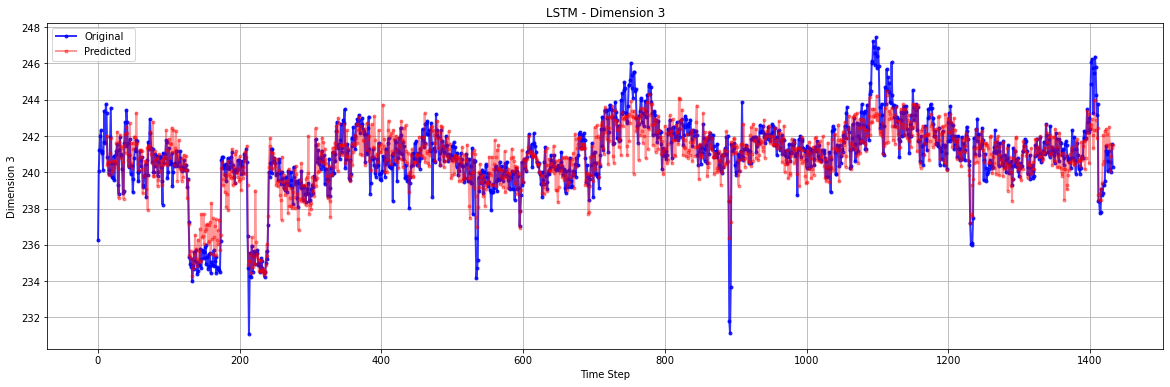

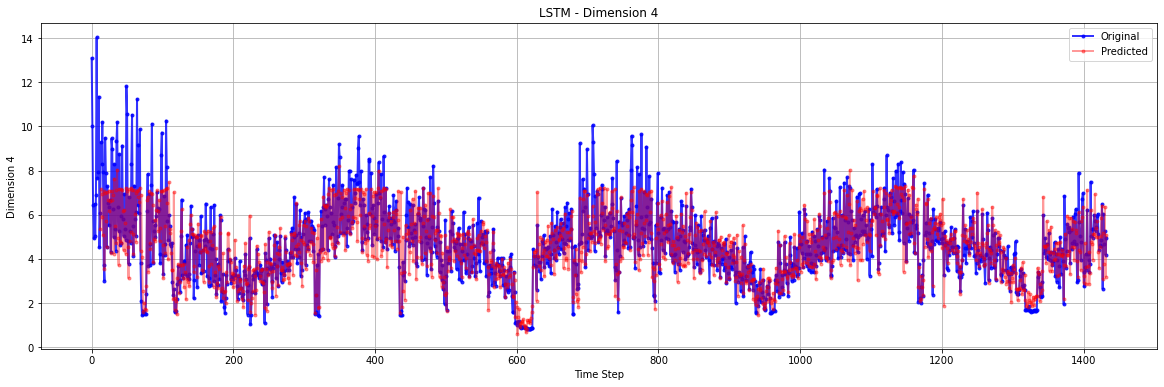

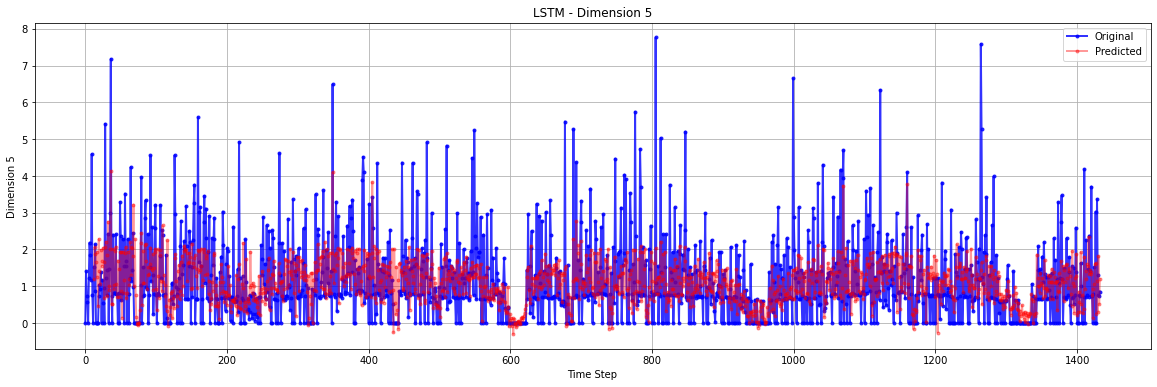

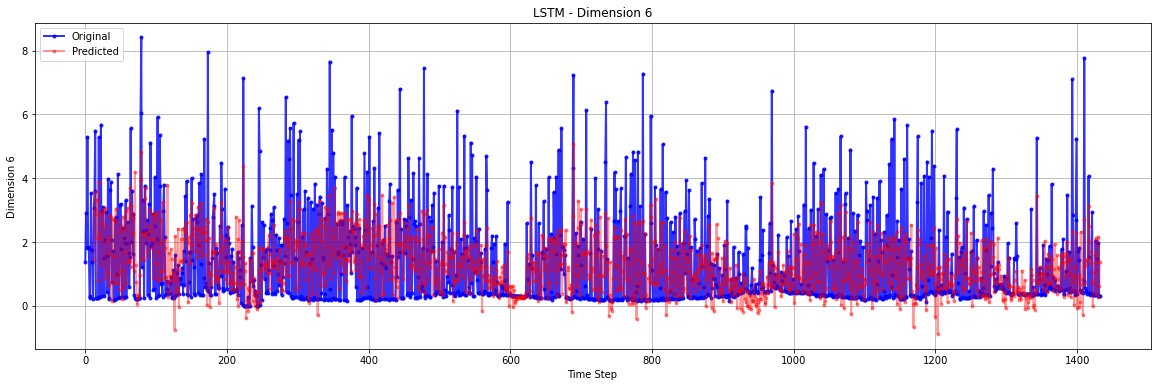

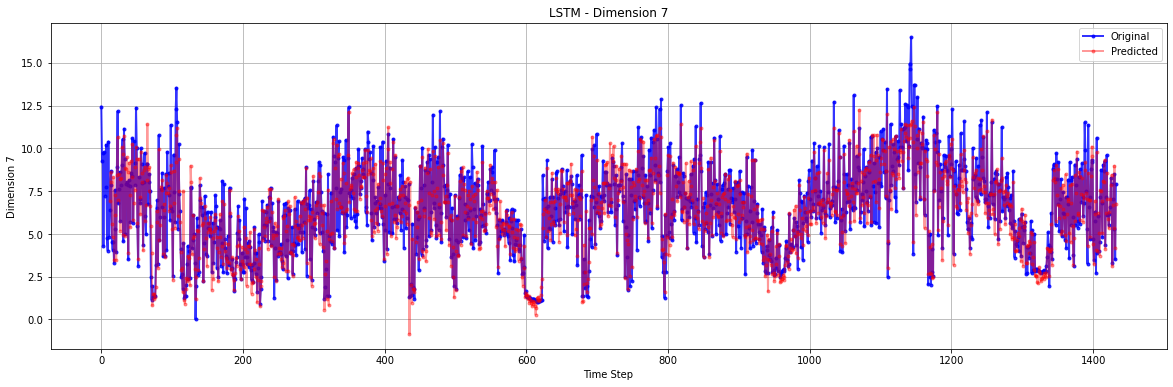

In [113]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(time_series).float()[:, dim], color='blue', label='Original', linewidth=2,marker='.',alpha=0.8)
    plt.plot(range(12, len(time_series)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=0.4,marker='.')
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [105]:
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data

In [106]:
x.requires_grad = True
outputs = lstm_model(x)        
loss = criterion(outputs, y)
loss.backward(retain_graph=True)
data_grad = x.grad.data

In [107]:
perturbed_data = fgsm_attack(x, 0.2, data_grad)
perturbed_predicted = lstm_model(perturbed_data).detach().numpy()
print(perturbed_predicted.shape)

(1421, 7)


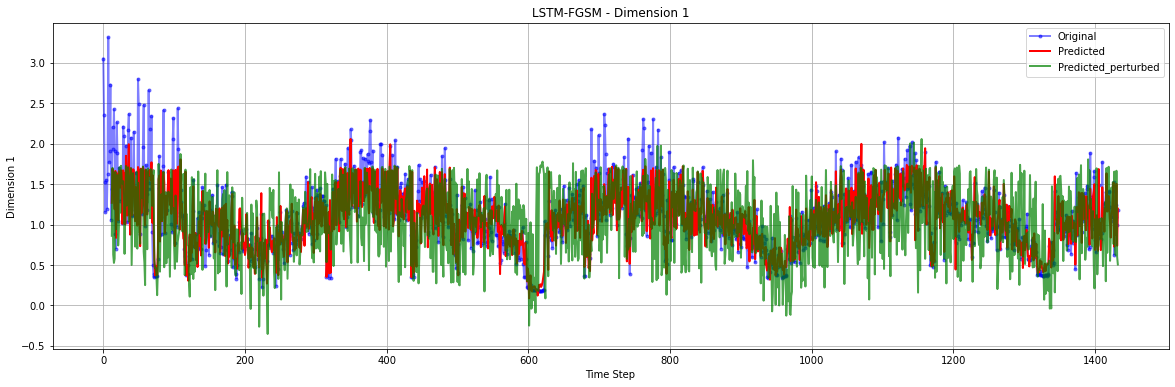

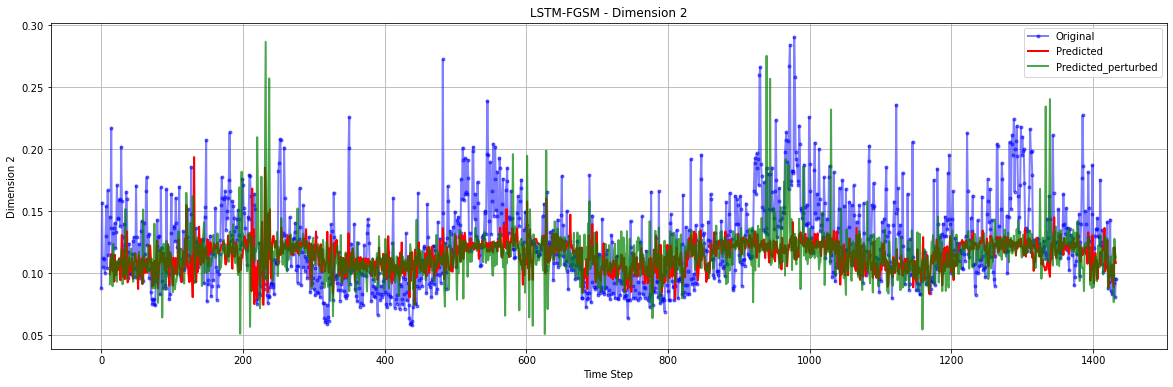

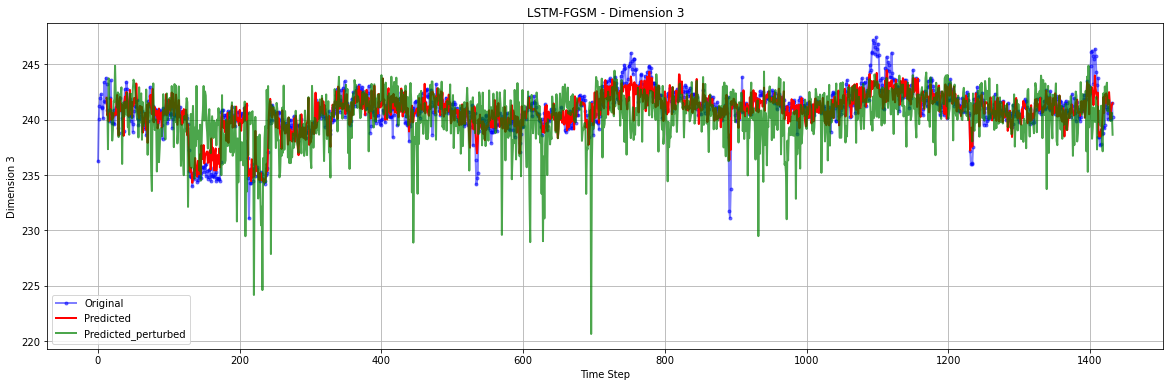

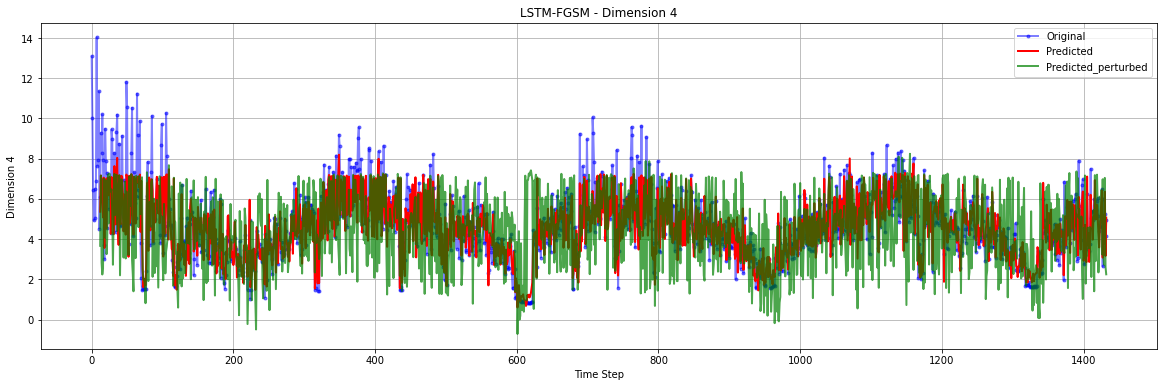

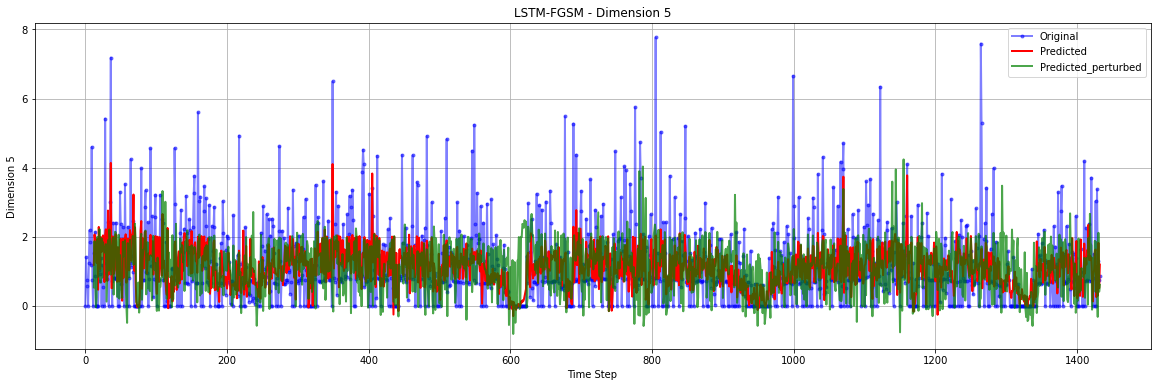

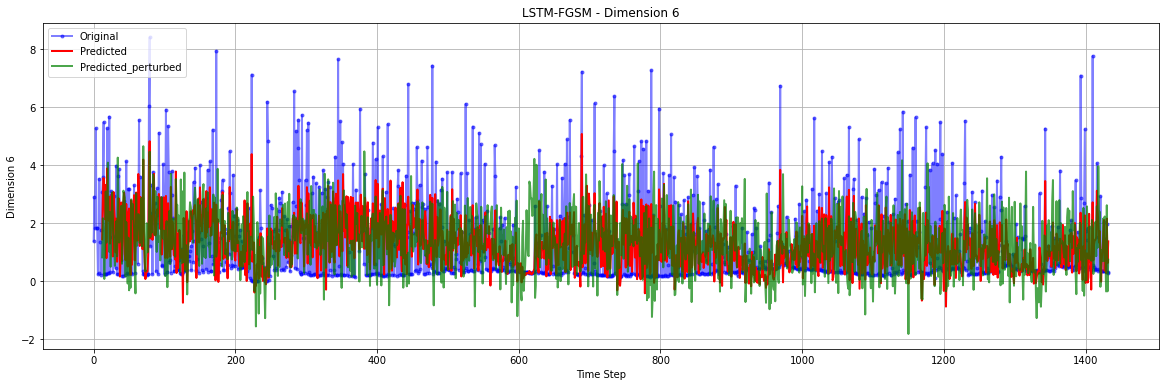

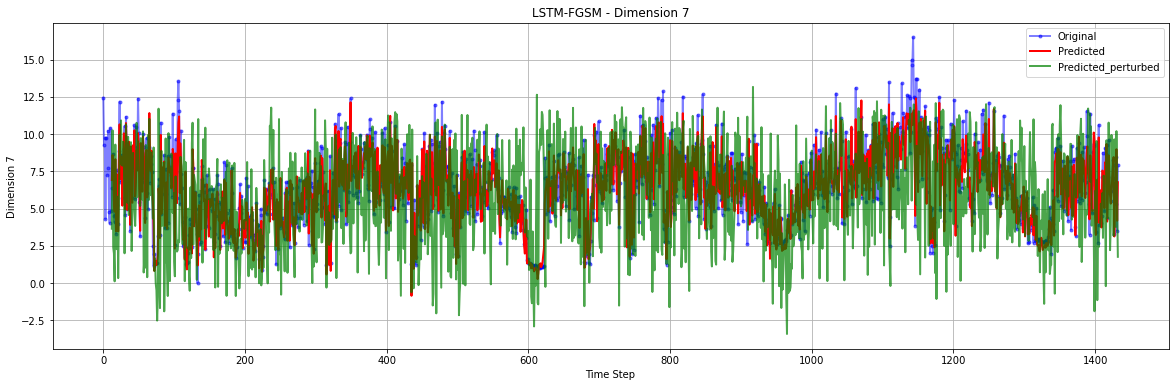

In [108]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(time_series).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(time_series)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(time_series)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM-FGSM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [109]:
# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs, Y)
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

In [110]:
perturbed_data = bim(x, y, lstm_model, epsilon=0.2, alpha=0.002, I=200)
print(perturbed_data.shape)
# Generate predictions from the perturbed data
perturbed_x = perturbed_data.float()
perturbed_predicted = lstm_model(perturbed_x).detach().numpy()
print(perturbed_predicted.shape)

torch.Size([1421, 10, 7])
(1421, 7)


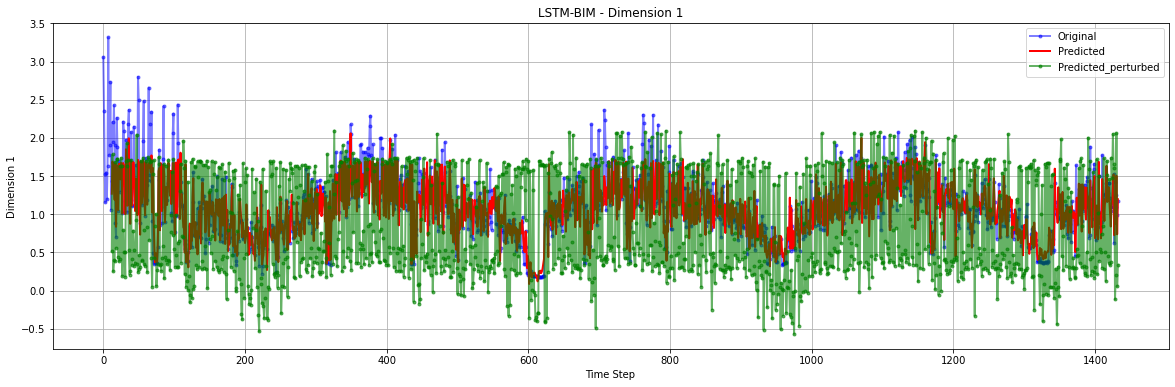

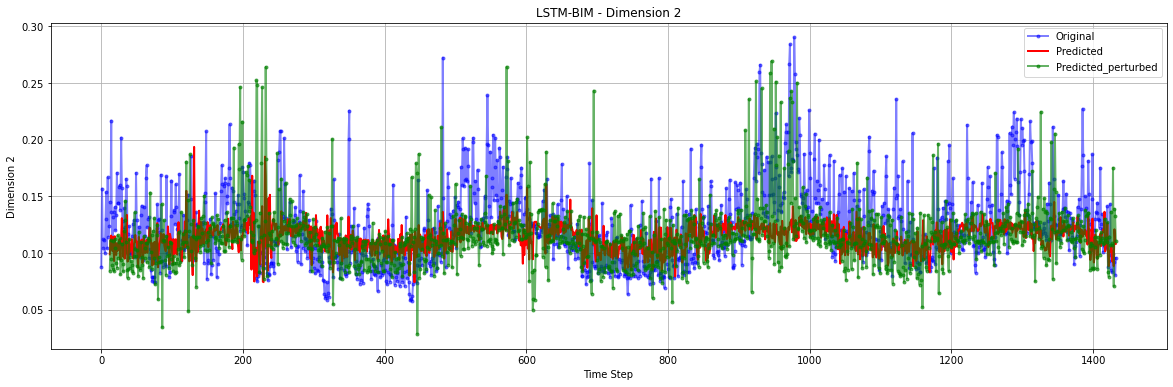

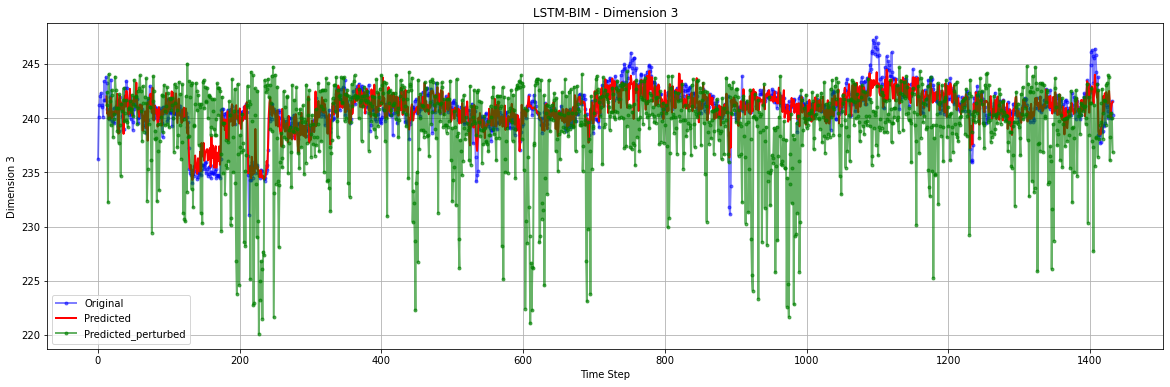

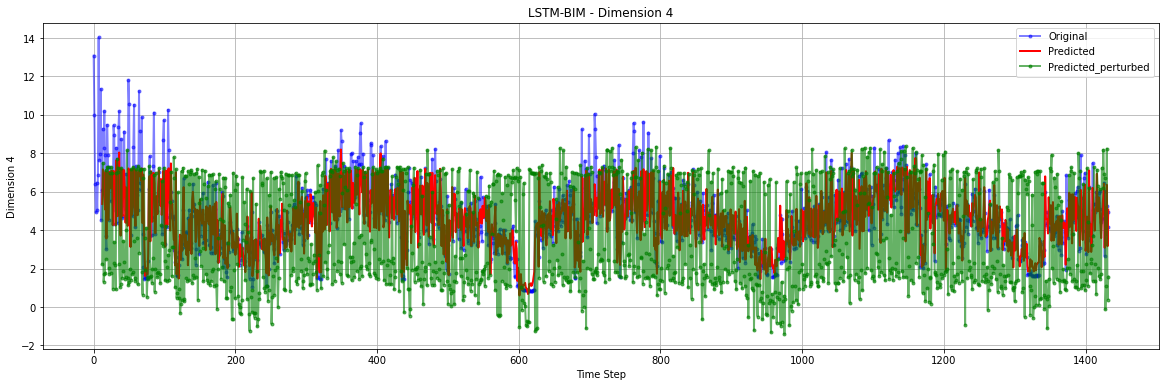

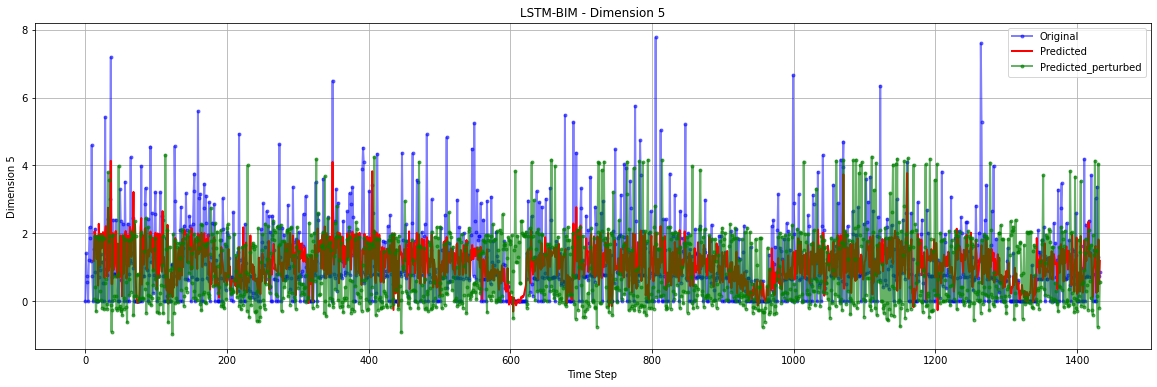

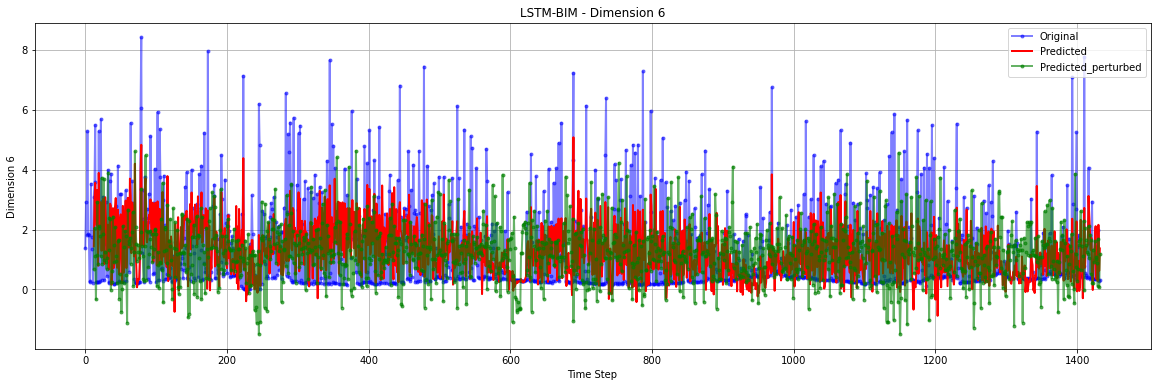

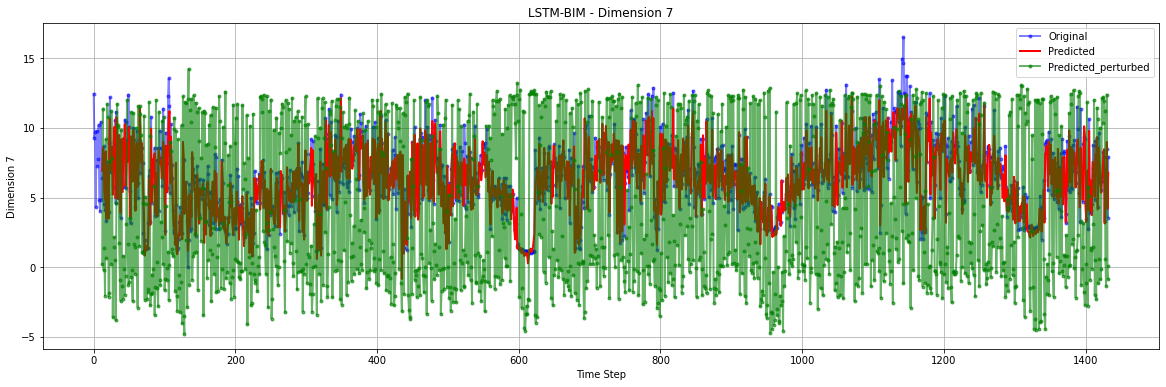

In [114]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(time_series).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(time_series)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(time_series)), perturbed_predicted[:, dim],marker='.', color='green', label='Predicted_perturbed', linewidth=2, alpha=0.6)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM-BIM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()